# Welcome to the 3D Object Detection & Visualization Workshop!
In this notebook, you'll work with a sequence of images and point clouds, and will learn to run 3D object detection algorithms to them. We will also learn how to visualize our results in 2D and 3D environments. So let us begin.
<p>

**Note:** This notebook has been adapted for educational purpose from [this repo](https://github.com/hailanyi/3D-Detection-Tracking-Viewer), and the model is running with weights downloaded on [this repo](https://github.com/open-mmlab/OpenPCDet).

In [ ]:
# !pip install spconv-cu118 -q
!pip install SharedArray2 -q
!pip install ipyvtklink -q
!pip install pyquaternion==0.9.9

In [ ]:
!pip install rerun-sdk==0.22.1

### Please restart the kernel by clicking: Run-> Restart and clear cell outputs

## 1. Imports

In [2]:
# now run 
import os
import sys
sys.path.append('/kaggle/input/4d-dataset/')
sys.path.append('/kaggle/input/4d-dataset/multi_object_tracking/multi_object_tracking')
sys.path.append("/kaggle/input/4d-dataset/viewer")
sys.path.append("/kaggle/input/4d-dataset/pointrcnn/pointrcnn")
sys.path.append("/kaggle/input/4d-dataset/pointrcnn/pointrcnn/pcdet")

In [3]:
import time
import tqdm
import logging
import argparse
from pathlib import Path
import yaml
import json
from easydict import EasyDict
from collections.abc import Sequence
from dataclasses import dataclass
from typing import Any, Final
import glob
from tqdm import tqdm
import cv2
import shutil
import requests
import re
from PIL import Image
from scipy.spatial.transform import Rotation as R
from IPython.display import FileLink, display

In [4]:
import numpy as np
import numpy.typing as npt
import torch
import rerun as rr
import matplotlib.pyplot as plt
import rerun.blueprint as rrb  
from scipy.spatial.transform import Rotation as R 

In [5]:
from dataset.kitti_data_base import velo_to_cam
from dataset.kitti_data_base import *  # si nécessaire
from utils import *                    # utils du viewer

In [6]:
from pcdet.ops.roiaware_pool3d import roiaware_pool3d_cuda
from pcdet.config import cfg, cfg_from_yaml_file
from pcdet.datasets import DatasetTemplate
from pcdet.utils import common_utils
from pcdet.utils.box_utils import project_3d_box_to_image
from box_3d import Box3D

## 2. Data

In [7]:
class KittiDataset(DatasetTemplate):
    def __init__(self,root_path,seq_id, dataset_cfg, class_names, label_path = None):
        super().__init__(
            dataset_cfg=dataset_cfg, class_names=class_names, training=False, root_path=root_path
        )
        self.seq_name = str(seq_id).zfill(4)
        self.root_path = root_path
        self.velo_path = os.path.join(self.root_path,"velodyne", self.seq_name)
        self.image_path = os.path.join(self.root_path,"image_02", self.seq_name)
        self.calib_path = os.path.join(self.root_path,"calib")
        self.label_path = label_path
        pose_path = os.path.join(self.root_path, "pose", self.seq_name,'pose.txt')
        self.poses = read_pose(pose_path)

    def __len__(self):
        return len(os.listdir(self.velo_path))

    def __getitem__(self, item):
        input_dict = {}
        name = str(item).zfill(6)
        velo_path = os.path.join(self.velo_path,name+'.bin')
        image_path = os.path.join(self.image_path, name+'.png')
        calib_path = os.path.join(self.calib_path, self.seq_name+'.txt')

        input_dict["frame_id"] = item

        pose = self.poses[item] if item in self.poses.keys() else None;
        input_dict["pose"] = pose

        P2,V2C = read_calib(calib_path)
        input_dict["P2"] = P2
        input_dict["V2C"] = V2C

        points = read_velodyne(velo_path,P2,V2C)
        input_dict["points"] = points

        image = read_image(image_path)
        input_dict["image"] = image

        objects, objects_cam, det_scores, det_names = [], [], [], []

        if self.label_path is not None:
            # If we have a label path, we'll read the labels instead of predicting them
            label_path = os.path.join(self.label_path, self.seq_name, name+'.txt')
            objects, det_scores, det_names = self.read_detection_label(label_path)
        if len(objects)>0:
            objects_cam = np.copy(objects)
            objects[:,3:6] = cam_to_velo(objects[:,3:6],V2C)[:,:3]
        input_dict["objects"] = objects
        input_dict["objects_cam"] = objects_cam
        input_dict["scores"] = det_scores
        input_dict["names"] = det_names

        return input_dict

    def read_detection_label(self,label_path):
        objects_list = []
        det_scores = []
        det_names = []
        with open(label_path) as f:
            for each_ob in f.readlines():
                infos = re.split(' ', each_ob)
                if infos[0] in ['Car', 'Truck','Van', 'Cyclist']:
                    objects_list.append(infos[8:15])
                    det_scores.append(infos[15])
                    det_names.append(infos[0])
        return np.array(objects_list, np.float32), np.array(det_scores, np.float32), det_names

In [ ]:
cfg_file = '4d-dataset/pointrcnn/pointrcnn/pointrcnn.yaml'## this further uses kitti_dataset.yaml

In [9]:
cfg_from_yaml_file(cfg_file, cfg)

{'ROOT_DIR': PosixPath('/kaggle/input/4d-dataset/pointrcnn/pointrcnn'),
 'LOCAL_RANK': 0,
 'CLASS_NAMES': ['Car', 'Pedestrian', 'Cyclist'],
 'DATA_CONFIG': {'DATASET': 'KittiDataset',
  'DATA_PATH': '../data/kitti',
  'POINT_CLOUD_RANGE': [0, -40, -3, 70.4, 40, 1],
  'DATA_SPLIT': {'train': 'train', 'test': 'val'},
  'INFO_PATH': {'train': ['kitti_infos_train.pkl'],
   'test': ['kitti_infos_val.pkl']},
  'GET_ITEM_LIST': ['points'],
  'FOV_POINTS_ONLY': True,
  'DATA_AUGMENTOR': {'DISABLE_AUG_LIST': ['placeholder'],
   'AUG_CONFIG_LIST': [{'NAME': 'gt_sampling',
     'USE_ROAD_PLANE': True,
     'DB_INFO_PATH': ['kitti_dbinfos_train.pkl'],
     'PREPARE': {'filter_by_min_points': ['Car:5',
       'Pedestrian:5',
       'Cyclist:5'],
      'filter_by_difficulty': [-1]},
     'SAMPLE_GROUPS': ['Car:20', 'Pedestrian:15', 'Cyclist:15'],
     'NUM_POINT_FEATURES': 4,
     'DATABASE_WITH_FAKELIDAR': False,
     'REMOVE_EXTRA_WIDTH': [0.0, 0.0, 0.0],
     'LIMIT_WHOLE_SCENE': True},
    {'NAM

In [ ]:
cfg.CLASS_NAMES

In [ ]:
root="4d-dataset/data/data"
label_dir = "4d-dataset/multi_object_tracking/multi_object_tracking/detectors/second_iou"

dataset = KittiDataset(root,seq_id=8,label_path=label_dir,
                       dataset_cfg = cfg.DATA_CONFIG, class_names = cfg.CLASS_NAMES)

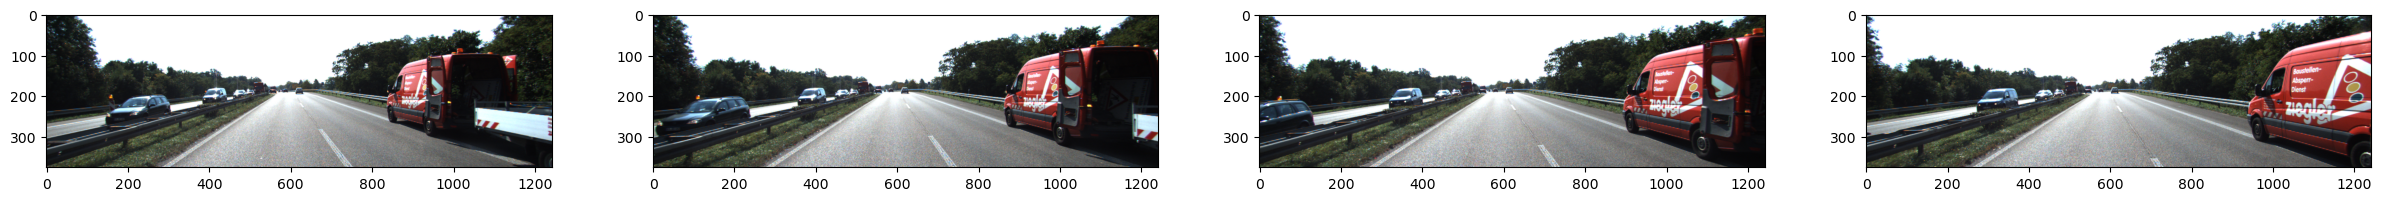

In [11]:
def view_images(images_to_be_shown):
  _, axs = plt.subplots(1, len(images_to_be_shown), figsize=(30, 30))

  if len(images_to_be_shown)> 1:
    axs = axs.flatten()
    for img, ax in zip(images_to_be_shown, axs):
        ax.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
  else:
        axs.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
      
  plt.show()


hand_picked_frames = [0,1,2,3]
images_2d = [dataset[i]["image"] for i in hand_picked_frames]

view_images(images_2d)

## 3. Data & Label Visualization (3D Viewer)

In [12]:
def visualize(dataset, frames=None, output_path=None,score_threshold=0.8, viz_labels=False):
    rr.init("KITTI Visualizer", recording_id="new_run", spawn=False)

    blueprint = rrb.Blueprint(
        rrb.Horizontal(
            rrb.Spatial2DView(origin="world/ego_vehicle/camera", name="Camera"),
            rrb.Spatial3DView(origin="world/ego_vehicle/lidar", name="LiDAR"),
            column_shares=[1, 1]
        )
    )

    rr.log("world/ego_vehicle/camera/", rr.ViewCoordinates.RIGHT_HAND_Y_DOWN)
    rr.log("world/ego_vehicle/lidar/", rr.ViewCoordinates.RIGHT_HAND_Z_UP)

    class_colors = {
        'Car': [255, 0, 0, 128],
        'Pedestrian': [0, 255, 0, 128],
        'Cyclist': [0, 0, 255, 128]
    }

    if frames is None:
        frames = list(range(len(dataset)))

    for i in frames:
        rr.set_time_sequence("frame", i)
        rr.log("world/ego_vehicle/camera/image/detections", rr.Clear(recursive=True))
        rr.log("world/ego_vehicle/lidar/boxes", rr.Clear(recursive=True))

        data = dataset[i]
        image = np.array(data['image'])
        points = data['points']
        P2, V2C = data['P2'], data['V2C']
        pose = data['pose']

        if pose is not None:  
            # Extract translation and rotation from pose matrix  
            translation = pose[:3, 3]  # Extract translation from 4x4 pose matrix  
            rotation_matrix = pose[:3, :3]  # Extract rotation matrix  
            # Convert rotation matrix to quaternion  
            r = R.from_matrix(rotation_matrix)  
            quat_xyzw = r.as_quat()  # scipy returns [x, y, z, w]  
              
            rr.log("world/ego_vehicle", rr.Transform3D(  
                translation=translation,  
                quaternion=rr.Quaternion(xyzw=quat_xyzw),  
                relation=rr.TransformRelation.ParentFromChild,  
            )) 
        
        rr.log("world/ego_vehicle/camera/image", rr.Image(cv2.cvtColor(image, cv2.COLOR_BGR2RGB)))
        
        positions = points[:, :3]
        distances = np.linalg.norm(positions, axis=1)
        norm = (255.0 * (distances - distances.min()) / (np.ptp(distances) + 1e-5)).astype(np.uint8)
        colors = (plt.cm.cividis(norm / 255.0)[:, :3] * 255).astype(np.uint8)
        rr.log("world/ego_vehicle/lidar/points", rr.Points3D(positions=positions, colors=colors))

        if viz_labels:
            centers, sizes, rotations, labels, box_colors = [], [], [], [], []
    
            for j, (box, box_cam, score, name) in enumerate(zip(data['objects'], data['objects_cam'], data['scores'], data['names'])):
                if score < score_threshold:
                    continue
    
                # 3D Camera Boxes
                corners_2d = project_3d_box_to_image(box_cam,P2)
                edges = [
                    [0, 1], [1, 2], [2, 3], [3, 0],
                    [4, 5], [5, 6], [6, 7], [7, 4],
                    [0, 4], [1, 5], [2, 6], [3, 7]
                ]
                lines = [np.array([corners_2d[start], corners_2d[end]]) for start, end in edges]
                box_colors.append(class_colors.get(name, [128, 128, 128, 128]))
    
                rr.log(f"world/ego_vehicle/camera/image/detections/box_{j}", rr.LineStrips2D(lines, labels=[f"{name} {score:.2f}"], colors=np.array(box_colors)))
                rr.log(f"world/ego_vehicle/camera/image/detections/box_{j}/label", rr.Points2D([np.mean(corners_2d, axis=0)], colors=np.array(box_colors)))
                
    
                # 3D Lidar boxes 
                h, w, l, x, y, z, ry = box  
                # Convert KITTI rotation to Rerun coordinate system  
                yaw = -ry - np.pi / 2  
                center = np.array([x, y, z + h / 2])  
                size = np.array([l, w, h])  
  
                # Create quaternion for rotation around Z-axis in Rerun's coordinate system  
                quat = R.from_euler('z', yaw, degrees=False).as_quat()  
                # Rerun expects [w, x, y, z] format  
                quat = np.array([quat[0], quat[1], quat[2], quat[3]])
    
                centers.append(center)
                sizes.append(size)
                rotations.append(quat)
                labels.append(f"{name} {score:.2f}")
    
            if centers:
                rr.log("world/ego_vehicle/lidar/boxes", rr.Boxes3D(
                    centers=np.array(centers),
                    half_sizes=np.array(sizes) / 2,
                    quaternions=np.array(rotations),
                    labels=labels,
                    colors=np.array(box_colors),
                    fill_mode="solid"
                ))

    rr.save(output_path, default_blueprint=blueprint)
    print(f"Visualization saved. Run:\nrerun {output_path}")

In [13]:
out_path = "/kaggle/working/data.rrd"
visualize(dataset, output_path = out_path, frames=range(220,270), viz_labels=False)

### If your code breaks, the rerun will break. Make
#rr.save("test.rrd")

Visualization saved. Run:
rerun /kaggle/working/data.rrd


Try to visualize One Frame, then some Hand Picked Frames, then the entire video!

### Label Visualization

![img](https://thinkautonomous-3d-tracking.s3.us-west-2.amazonaws.com/download+(1)+(1).jpeg)

In [14]:
out_path = "/kaggle/working/labels55.rrd"
visualize(dataset, output_path = out_path, frames=range(200,300), viz_labels=True)

### If your code breaks, the rerun will break. Make
#rr.save("test.rrd")

Visualization saved. Run:
rerun /kaggle/working/labels55.rrd


## 4. 3D Object Detection
Later in the course, we'll work with Object Trackers. There are 2 types of trackers:
1.   **Separate Trackers**
2.   **Joint Trackers**

The first type first detect objects and then track them (using algorithms we explore in the course). The second type directly outputs tracking based on a sequence (2 images or files sent to a neural network, a tracking input).

In this notebook, we'll use the **first type**. And therefore our first task will be to detect the objects.
<p>

In this notebook, we'll focus on tracking and therefore run this as black box. You'll still be able to understand how this works, play with the point clouds, inputs and outputs. If you'd like more details on the inside of this architecture, I refer you to my course [DEEP POINT CLOUDS](https://courses.thinkautonomous.ai/deep-point-clouds).
<p>

![](https://raw.githubusercontent.com/sshaoshuai/PointRCNN/master/doc/teaser.png)

#### PointRCNN
We'll use the library OpenPCDet, which will implement the PointRCNN algorithm based on [this repo](https://github.com/open-mmlab/OpenPCDet).<p>

In [15]:
from pcdet.models import build_network, load_data_to_gpu

/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:98: UserWarning: unable to load libtensorflow_io_plugins.so: unable to open file: libtensorflow_io_plugins.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io_plugins.so: undefined symbol: _ZN3tsl6StatusC1EN10tensorflow5error4CodeESt17basic_string_viewIcSt11char_traitsIcEENS_14SourceLocationE']
  warnings.warn(f"unable to load libtensorflow_io_plugins.so: {e}")
/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/__init__.py:104: UserWarning: file system plugins are not loaded: unable to open file: libtensorflow_io.so, from paths: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so']
caused by: ['/opt/conda/lib/python3.10/site-packages/tensorflow_io/python/ops/libtensorflow_io.so: undefined symbol: _ZTVN10tenso

In [16]:
import argparse
import glob
from pathlib import Path
import torch

In [17]:
from box_3d import *

In [18]:
model_ckpt = '/kaggle/input/4d-dataset/pointrcnn/pointrcnn/pointrcnn_7870.pth'

output_file_dir = f'/kaggle/working/3d_object_detection_results/0008'
id_to_name = {1: 'Car', 2: 'Pedestrian', 3: 'Cyclist', 4: 'Van'}

In [19]:
print(cfg.CLASS_NAMES)

['Car', 'Pedestrian', 'Cyclist']


In [20]:
logger = common_utils.create_logger()
logger.info(f"CLASS_NAMES: {cfg.CLASS_NAMES}")

2025-06-07 21:34:44,628   INFO  CLASS_NAMES: ['Car', 'Pedestrian', 'Cyclist']


In [21]:
model = build_network(model_cfg=cfg.MODEL, num_class=len(cfg.CLASS_NAMES), dataset=dataset)
model.load_params_from_file(filename=model_ckpt,logger=logger, to_cpu=True)
model.cuda()

2025-06-07 21:34:45,163   INFO  ==> Loading parameters from checkpoint /kaggle/input/4d-dataset/pointrcnn/pointrcnn/pointrcnn_7870.pth to CPU
2025-06-07 21:34:45,409   INFO  ==> Done (loaded 309/309)


PointRCNN(
  (vfe): None
  (backbone_3d): PointNet2MSG(
    (SA_modules): ModuleList(
      (0): PointnetSAModuleMSG(
        (groupers): ModuleList(
          (0-1): 2 x QueryAndGroup()
        )
        (mlps): ModuleList(
          (0): Sequential(
            (0): Conv2d(4, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (2): ReLU()
            (3): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (4): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (5): ReLU()
            (6): Conv2d(16, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (7): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (8): ReLU()
          )
          (1): Sequential(
            (0): Conv2d(4, 32, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (1): BatchNorm2d(32,

In [22]:
!mkdir -p '/kaggle/working/3d_object_detection_results/0008'

In [23]:
def limit_period(val, offset=0.5, period=np.pi):
    """Limit the value into a period for periodic function.
    Args:
        val (torch.Tensor | np.ndarray): The value to be converted.
        offset (float, optional): Offset to set the value range.
            Defaults to 0.5.
        period ([type], optional): Period of the value. Defaults to np.pi.
    Returns:
        (torch.Tensor | np.ndarray): Value in the range of
            [-offset * period, (1-offset) * period]
    """
    limited_val = val - np.floor(val / period + offset) * period
    return limited_val

In [24]:
print(len(dataset))

390


In [25]:
hand_picked_frames = range(len(dataset))
print(len(hand_picked_frames))

390


In [26]:
model.eval()
with torch.no_grad():
  for i in hand_picked_frames:
      print(i)
      inference_result = []
      #read data
      data_dict = {k: dataset[i][k] for k in ["points","frame_id"] if k in dataset[i]}
      data_dict = dataset.collate_batch([data_dict])
      load_data_to_gpu(data_dict)

      #Forward propagation
      pred_dicts, _ = model.forward(data_dict)
      points=data_dict['points']#[:, :3]
      bboxes=pred_dicts[0]['pred_boxes'].cpu().detach().numpy()
      scores=pred_dicts[0]['pred_scores'].cpu().detach().numpy()
      labels=pred_dicts[0]['pred_labels'].cpu().detach().numpy()
      P2 = np.column_stack((dataset[i]["P2"].T, [0,0,1,0]))

      #Postprocess
      inference_result.append([])
      for bbox, score, label in zip(bboxes, scores, labels):
          pos = bbox[:3]  # x, y, z
          dim = bbox[[4, 5, 3]]   # w, h, l
          yaw = bbox[-1]
          yaw = -yaw - np.pi / 2
          yaw = limit_period(yaw, period=np.pi * 2)
          label_name = id_to_name[label]
          box3d = Box3D(pos, dim, yaw, label_name, score, dataset[i]["V2C"].T, P2)
          inference_result[-1].append(box3d)
      #Write to file
      output_file_name = output_file_dir + '/' + str(i).zfill(6) + '.txt'
      f = open(output_file_name, 'w+')
      for each_3d_box in inference_result[0]:
          f.write(each_3d_box.to_kitti_format(each_3d_box.confidence))
          f.write('\n')
      f.close()

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
27

In [27]:
print(bboxes)
print(scores)
print(labels)

[[ 2.6499647e+01  3.0950508e+00 -8.1166625e-01  3.5747054e+00
   1.6219648e+00  1.5054818e+00  1.3467427e-02]
 [ 9.4107018e+00  6.3128037e+00 -8.7567014e-01  3.8852544e+00
   1.5898902e+00  1.4644556e+00  4.5986194e-03]
 [ 1.1567557e+01  9.1840200e+00  6.3140735e-02  6.3155347e-01
   7.2839624e-01  1.7711006e+00 -9.2113632e-01]
 [ 4.1771027e+01  6.7305384e+00 -5.0234634e-01  1.9103885e+00
   6.3616228e-01  1.8346412e+00 -1.7758496e-01]]
[0.9999777  0.999845   0.84979135 0.49955466]
[1 1 2 3]


In [28]:
label_path = "/kaggle/working/3d_object_detection_results"
output_path = "/kaggle/working/pointrcnn.rrd"

dataset = KittiDataset(root,seq_id = 8, label_path=label_path, dataset_cfg=cfg.DATA_CONFIG, class_names=cfg.CLASS_NAMES)

visualize(dataset, output_path = output_path, frames=hand_picked_frames, viz_labels=True)

Visualization saved. Run:
rerun /kaggle/working/pointrcnn.rrd


### 3.2. Try another model

In [ ]:
#cfg_file = '/kaggle/input/4d-perception-second/second.yaml'
cfg_file = '/kaggle/input/4d-perception-second/PartA2_free.yaml'

cfg_from_yaml_file(cfg_file, cfg)

logger = common_utils.create_logger()

from pcdet.datasets import build_dataloader
dataset, dataloader, _ = build_dataloader(
    dataset_cfg=cfg.DATA_CONFIG,
    class_names=cfg.CLASS_NAMES,
    batch_size=1,
    dist=False,
    workers=0,
    logger=logger,
    training=False
)

#model_ckpt = '/kaggle/input/4d-perception-second/second_7862.pth'
model_ckpt = '/kaggle/input/4d-perception-second/PartA2_free_7872.pth'

from pcdet.models import build_network
model = build_network(model_cfg=cfg.MODEL, num_class=len(cfg.CLASS_NAMES), dataset=dataset)
model.load_params_from_file(filename=model_ckpt, logger=logger, to_cpu=False)
model.cuda()
model.eval()

data_dict = dataset[0]
from pcdet.datasets.collate_utils import collate_batch
from pcdet.utils.common_utils import move_data_to_device

batch = collate_batch([data_dict])
move_data_to_device(batch, device=torch.device("cuda"))
preds, _ = model(batch)


## 5. Visualize Tracking

In [29]:
from dataset.kitti_data_base import read_tracking_label

In [30]:
def visualize_tracking(dataset, tracking_label_path, frames=None, output_path=None, score_threshold=0.8):  
    rr.init("KITTI Tracking Visualizer", recording_id="tracking_run", spawn=False)  
      
    blueprint = rrb.Blueprint(  
        rrb.Spatial3DView(origin="world/ego_vehicle/lidar", name="LiDAR Tracking")  
    )  
      
    # Set coordinate system for LiDAR space  
    rr.log("world/ego_vehicle/lidar/", rr.ViewCoordinates.RIGHT_HAND_Z_UP)  
      
    # Load tracking data  
    tracking_frame_dict, tracking_names_dict = read_tracking_label(tracking_label_path)  
      
    if frames is None:  
        frames = list(range(len(dataset)))  
      
    # Store trajectories for visualization  
    trajectories = {}  # track_id -> list of center_3d positions  
      
    for i in frames:  
        rr.set_time_sequence("frame", i)  
        rr.log("world/ego_vehicle/lidar/boxes", rr.Clear(recursive=True))  
        rr.log("world/ego_vehicle/lidar/trajectories", rr.Clear(recursive=True))  
          
        data = dataset[i]  
        points = data['points']  
        pose = data['pose']  
  
        if pose is not None:  
            # Extract translation and rotation from pose matrix  
            translation = pose[:3, 3]  # Extract translation from 4x4 pose matrix  
            rotation_matrix = pose[:3, :3]  # Extract rotation matrix  
            # Convert rotation matrix to quaternion  
            r = R.from_matrix(rotation_matrix)  
            quat_xyzw = r.as_quat()  # scipy returns [x, y, z, w]  
              
            rr.log("world/ego_vehicle", rr.Transform3D(  
                translation=translation,  
                quaternion=rr.Quaternion(xyzw=quat_xyzw),  
                relation=rr.TransformRelation.ParentFromChild,  
            ))  
          
        # Log point cloud with distance-based coloring  
        positions = points[:, :3]  
        distances = np.linalg.norm(positions, axis=1)  
        norm = (255.0 * (distances - distances.min()) / (np.ptp(distances) + 1e-5)).astype(np.uint8)  
        colors = (plt.cm.cividis(norm / 255.0)[:, :3] * 255).astype(np.uint8)  
        rr.log("world/ego_vehicle/lidar/points", rr.Points3D(positions=positions, colors=colors))  
          
        if i not in tracking_frame_dict:  
            continue  
          
        track_data = tracking_frame_dict[i]  
        track_names = tracking_names_dict[i]  
          
        centers, sizes, rotations, labels, colors = [], [], [], [], []  
          
        for entry, name in zip(track_data, track_names):  
            h, w, l, x, y, z, ry, track_id = entry  
              
            if l * w * h == 0:  # Skip invalid boxes  
                continue  
              
            # KITTI coordinate system: X=right, Y=down, Z=forward  
            # Rerun RIGHT_HAND_Z_UP: X=right, Y=forward, Z=up  
            center = np.array([z, -x, -y + h / 2])  # Transform KITTI to Rerun coordinates  
            size = np.array([l, w, h])    
              
            # Fix rotation: Ensure boxes are horizontal and properly oriented  
            # For horizontal boxes in the XY plane, we need to adjust the rotation  
            yaw = -ry + np.pi / 2  # Adjust rotation to keep boxes horizontal  
            quat = R.from_euler('z', yaw, degrees=False).as_quat()  
            quat_rerun = np.array([quat[3], quat[0], quat[1], quat[2]])  # [w,x,y,z]  
              
            # Generate unique color per track ID  
            color = np.array([  
                (37 * track_id) % 255,  
                (17 * track_id) % 255,  
                (91 * track_id) % 255,  
                255  
            ]).astype(np.uint8)  
              
            centers.append(center)  
            sizes.append(size)  
            rotations.append(quat_rerun)  
            labels.append(f"ID {int(track_id)}")  
            colors.append(color)  
              
            # Store trajectory data with corrected coordinates  
            if track_id not in trajectories:  
                trajectories[track_id] = []  
            trajectories[track_id].append(center.copy())  
          
        # Log 3D boxes  
        if centers:  
            rr.log("world/ego_vehicle/lidar/boxes", rr.Boxes3D(  
                centers=np.array(centers),  
                half_sizes=np.array(sizes) / 2,  
                quaternions=np.array(rotations),  
                labels=labels,  
                colors=np.array(colors),  
                fill_mode="solid"  
            ))  
          
        # Log trajectories with unique colors per track  
        for track_id, trajectory in trajectories.items():  
            if len(trajectory) > 1:  
                # Only show trajectory up to current frame  
                current_frame_trajectory = trajectory[:len([f for f in frames if f <= i])]  
                if len(current_frame_trajectory) > 1:  
                    trajectory_points = np.array(current_frame_trajectory)  
                      
                    # Generate the same unique color for this track ID as used for boxes  
                    trajectory_color = np.array([  
                        (37 * track_id) % 255,  
                        (17 * track_id) % 255,  
                        (91 * track_id) % 255,  
                        180  # Alpha for transparency  
                    ]).astype(np.uint8)  
                      
                    # Create trajectory line with unique color  
                    rr.log(  
                        f"world/ego_vehicle/lidar/trajectories/track_{track_id}",  
                        rr.LineStrips3D([trajectory_points], colors=[trajectory_color])  
                    )  
                      
                    # Mark trajectory points with the same color  
                    rr.log(  
                        f"world/ego_vehicle/lidar/trajectories/track_{track_id}/points",  
                        rr.Points3D(trajectory_points, colors=[trajectory_color], radii=[0.1])  
                    )  
      
    rr.save(output_path, default_blueprint=blueprint)  
    print(f"Tracking visualization saved. Run:\nrerun {output_path}")

In [31]:
#  Add the tracking path
preds_path = "/kaggle/working/3d_object_detection_results"
tracking_path = "/kaggle/input/4d-dataset/0008/0008.txt"
out_path_pred = "/kaggle/working/predictions_video_sequence11.rrd"
visualize_tracking(  
    dataset=dataset,  
    tracking_label_path=tracking_path,  
    frames=hand_picked_frames,  # First 30 frames  
    output_path=out_path_pred,  
    score_threshold=0.8  
)

Tracking visualization saved. Run:
rerun /kaggle/working/predictions_video_sequence11.rrd
